# Gated PixelCNN

In this notebook we implement the `gated PixelCNN` autoregressive generative model, including the version conditioned on the labels.

This notebook is highly inspired by the following [notebook](https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/tutorial12/Autoregressive_Image_Modeling.html) and we borrow many parts in our implementation. 

In [1]:
import time
import pathlib

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

import torchvision
import torchvision.transforms as T
from torchvision.datasets import MNIST

We use different parameters than in the two previous notebooks. We increase the number of epochs from 50 to 100 and increase the size of the channels from 16 to 64. These adjustments should produce higher quality digits.

In [2]:
## hyperparameters
NUM_EPOCHS = 100
BATCH_SIZE = 128
HIDDEN_DIM = 64
LEARNING_RATE = 1e-3
MIN_LEARNING_RATE = 1e-4
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

The `MaskedConvolution` module expects a mask as an input parameter. Horizonal and vertical stack will have different types of masks. We generate a convolutional layer based on the shape of the mask and multiply the weights of the convolution each forward pass to zero some of the weights.

In [3]:
class MaskedConvolution(nn.Module):
    
    def __init__(self, in_channels, out_channels, mask, dilation=1):
        super().__init__()
        kernel_size = mask.shape
        padding = tuple([dilation * (size-1)//2 for size in kernel_size])
        
        self.conv = nn.Conv2d(in_channels=in_channels, 
                              out_channels=out_channels, 
                              kernel_size=kernel_size,
                              padding=padding,
                              dilation=dilation)
        self.register_buffer('mask', mask)
    
    def forward(self, x):
        with torch.no_grad():
            self.conv.weight *= self.mask 
        return self.conv(x)

The `VertickalStackConvolution` module processes the pixels above the pixel we would like to produce. We are still dealing with type 'A' and type 'B' masks. 'A' masks are only required for the very first layer, afterwards we are allowed to use type 'B' masks.

In [4]:
class VerticalStackConvolution(MaskedConvolution):
    def __init__(self, in_channels, out_channels, kernel_size=3, mask_type='B', dilation=1):
        assert mask_type in ['A', 'B']
        mask = torch.ones(kernel_size, kernel_size)
        mask[kernel_size//2+1:,:] = 0
        if mask_type=='A':
            mask[kernel_size//2,:] = 0
        
        super().__init__(in_channels, out_channels, mask, dilation=dilation)

In [5]:
# type A mask
vertical = VerticalStackConvolution(in_channels=1, out_channels=1, mask_type='A')
print(vertical.mask)
# type B mask
vertical = VerticalStackConvolution(in_channels=1, out_channels=1, mask_type='B')
print(vertical.mask)

tensor([[1., 1., 1.],
        [0., 0., 0.],
        [0., 0., 0.]])
tensor([[1., 1., 1.],
        [1., 1., 1.],
        [0., 0., 0.]])


The `HorizontalStackConvolution` on the other hand attends to pixels to the left of the pixel we would like to generate.

In [6]:
class HorizontalStackConvolution(MaskedConvolution):
    def __init__(self, in_channels, out_channels, kernel_size=3, mask_type='B', dilation=1):
        assert mask_type in ['A', 'B']
        mask = torch.ones(1, kernel_size)
        mask[0, kernel_size//2+1:] = 0
        if mask_type=='A':
            mask[0, kernel_size//2] = 0
        super().__init__(in_channels, out_channels, mask, dilation=dilation)

In [7]:
# type A mask
horizontal = HorizontalStackConvolution(in_channels=1, out_channels=1, mask_type='A')
print(horizontal.mask)

# type B mask
horizontal = HorizontalStackConvolution(in_channels=1, out_channels=1, mask_type='B')
print(horizontal.mask)

tensor([[1., 0., 0.]])
tensor([[1., 1., 0.]])


The `GatedResidualBlock` follows the [diagram](https://www.world4ai.org/blocks/deep_learning/generative_models/autoregressive/gated_pixel_cnn) we discussed in the theoretical section. We suggest you compare the diagram to the implementation.

In [8]:
class GatedResidualBlock(nn.Module):

    def __init__(self, in_channels, kernel_size=3, dilation=1):
        super().__init__()
        self.v = VerticalStackConvolution(in_channels, out_channels=2*in_channels, kernel_size=kernel_size, dilation=dilation)
        self.h = HorizontalStackConvolution(in_channels, out_channels=2*in_channels, kernel_size=kernel_size, dilation=dilation)
        self.v_to_h = nn.Conv2d(2*in_channels, 2*in_channels, kernel_size=1)
        self.v_to_res = nn.Conv2d(in_channels, in_channels, kernel_size=1)

    def forward(self, v_prev, h_prev):
        
        # vertical stack
        v = self.v(v_prev)
        v_f, v_g = v.chunk(2, dim=1)
        v_out = torch.tanh(v_f) * torch.sigmoid(v_g)

        # vertical to horizontal
        v_to_h = self.v_to_h(v)
        
        # horizontal stack
        h = self.h(h_prev) + v_to_h
        h_f, h_g = h.chunk(2, dim=1)
        h_out = torch.tanh(h_f) * torch.sigmoid(h_g)
        
        # skip connection
        h_out = self.v_to_res(h_out)
        h_out += h_prev

        return v_out, h_out

Finally we implement the full model. We start we a vertical and horizontal stack with a 7x7 kernel and a mask of type 'A'. The results are then processed by 7 3x3 type 'B' residual blocks. 

You should notice that the model uses convolutions with dilations. Normally a kernel attends to adjacent pixels, a kernel with dilations has gaps between the neurons, thus increasing the visual field. If this makes no sense here is a [link](https://github.com/vdumoulin/conv_arithmetic/blob/master/README.md) that provides a great visualizations.

In [9]:
class GatedPixelCNN(nn.Module):
    def __init__(self, hidden_dim, dilations=[1, 2, 1, 4, 1, 2, 1]):
        super().__init__()
        self.v = VerticalStackConvolution(in_channels=1,
                                          out_channels=hidden_dim,
                                          kernel_size=7,
                                          mask_type='A')
        self.h = HorizontalStackConvolution(in_channels=1,
                                          kernel_size=7,
                                          out_channels=hidden_dim,
                                          mask_type='A')
        
        self.gated_residual_blocks = nn.ModuleList([GatedResidualBlock(hidden_dim, kernel_size=3, dilation=dilation) 
                                                 for dilation in dilations])
        
        self.conv = nn.Conv2d(in_channels=hidden_dim, 
                              out_channels=hidden_dim,
                              kernel_size=1)
        
        # we apply a 256 way softmax
        self.output = nn.Conv2d(in_channels=hidden_dim, 
                                out_channels=256,
                                kernel_size=1)
    def forward(self, x):
        v = self.v(x)
        h = self.h(x)
        
        for gated_layer in self.gated_residual_blocks:
            v, h = gated_layer(v, h)
        
        out = self.conv(F.relu(h))
        out = self.output(F.relu(out))
        # from Batch, Classes, Height, Width to Batch, Classes, Channel, Height, Width
        out = out.unsqueeze(dim=2)
        return out

In [10]:
train_dataset = torchvision.datasets.MNIST(root='../datasets/', 
                                           train=True, 
                                           transform=T.PILToTensor(), 
                                           download=True)

test_dataset = torchvision.datasets.MNIST(root='../datasets/', 
                                           train=False, 
                                           transform=T.PILToTensor(), 
                                           download=False)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ../datasets/MNIST/raw/train-images-idx3-ubyte.gz to ../datasets/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ../datasets/MNIST/raw/train-labels-idx1-ubyte.gz to ../datasets/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ../datasets/MNIST/raw/t10k-images-idx3-ubyte.gz to ../datasets/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ../datasets/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../datasets/MNIST/raw



In [11]:
train_dataloader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True, num_workers=2)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False, drop_last=False, num_workers=2)

In [12]:
model = GatedPixelCNN(hidden_dim=HIDDEN_DIM).to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=5, min_lr=MIN_LEARNING_RATE, verbose=True)

In [13]:
try: 
    from google.colab import drive
    drive.mount('/content/gdrive')
    drive_path = pathlib.Path('/content/gdrive')
    weights_path = drive_path / 'MyDrive/weights'
except:
    weights_path = pathlib.Path('../weights')

Mounted at /content/gdrive


In [14]:
# training loop
def train():
    best_loss = float("inf")
    scaler = torch.cuda.amp.GradScaler()
    for epoch in range(NUM_EPOCHS):
        start_time = time.time()
        train_losses = []
        test_losses = []
        for features, _ in train_dataloader:
            optimizer.zero_grad()

            features = features.to(DEVICE)
            # we use automatic mixed precision for speedup
            with torch.amp.autocast(device_type="cuda", dtype=torch.float16):
                logits = model(features.float() / 255)
                loss = criterion(logits, features.long())

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            train_losses.append(loss.cpu().item())


        # evaluate on the test dataset
        with torch.inference_mode():
            for features, _ in test_dataloader:
                features = features.to(DEVICE)
                with torch.amp.autocast(device_type="cuda", dtype=torch.float16):
                    logits = model(features.float() / 255)
                    loss = criterion(logits, features.long())
                test_losses.append(loss.cpu().item())

        end_time = time.time()
        ce_train = sum(train_losses)/len(train_losses)
        ce_test = sum(test_losses)/len(test_losses)
        print(f'Epoch: {epoch+1}/{NUM_EPOCHS}, Cross Entropy Train: {ce_train:.4f}, Cross Entropy Test: {ce_test:.4f}, Elapsed Time: {end_time-start_time:.2f}sec')

        if ce_test < best_loss:
            print("Saving Weights")
            best_loss = ce_test
            torch.save(model.state_dict(), f=weights_path / 'gated_pixel_cnn.pt')
        scheduler.step(ce_test)

In [15]:
train()

Epoch: 1/100, Cross Entropy Train: 1.0015, Cross Entropy Test: 0.8129, Elapsed Time: 22.99sec
Saving Weights
Epoch: 2/100, Cross Entropy Train: 0.8033, Cross Entropy Test: 0.7901, Elapsed Time: 15.19sec
Saving Weights
Epoch: 3/100, Cross Entropy Train: 0.7852, Cross Entropy Test: 0.7748, Elapsed Time: 15.20sec
Saving Weights
Epoch: 4/100, Cross Entropy Train: 0.7732, Cross Entropy Test: 0.7637, Elapsed Time: 15.18sec
Saving Weights
Epoch: 5/100, Cross Entropy Train: 0.7647, Cross Entropy Test: 0.7599, Elapsed Time: 15.18sec
Saving Weights
Epoch: 6/100, Cross Entropy Train: 0.7587, Cross Entropy Test: 0.7500, Elapsed Time: 15.40sec
Saving Weights
Epoch: 7/100, Cross Entropy Train: 0.7535, Cross Entropy Test: 0.7471, Elapsed Time: 15.21sec
Saving Weights
Epoch: 8/100, Cross Entropy Train: 0.7474, Cross Entropy Test: 0.7501, Elapsed Time: 15.21sec
Epoch: 9/100, Cross Entropy Train: 0.7439, Cross Entropy Test: 0.7446, Elapsed Time: 15.17sec
Saving Weights
Epoch: 10/100, Cross Entropy Train

In [16]:
model.load_state_dict(torch.load(f=weights_path / 'gated_pixel_cnn.pt'))

<All keys matched successfully>

In [17]:
@torch.inference_mode()
def sample(model, num_images):
    width = 28
    height = 28
    img = torch.zeros((num_images, 1, height, width)).to(DEVICE)
    for h in range(height):
        for w in range(width):
                pred = model(img / 255.0)[:, :, :, h, w].squeeze()
                probs = F.softmax(pred, dim=1)
                sampled = torch.multinomial(probs, num_samples=1).squeeze(dim=-1)
                img[:, 0, h, w] = sampled
    return img

In [18]:
sampled_images = sample(model, 10)

The results look much better, but we could probably still getter results by increasing the model size and training for longer.

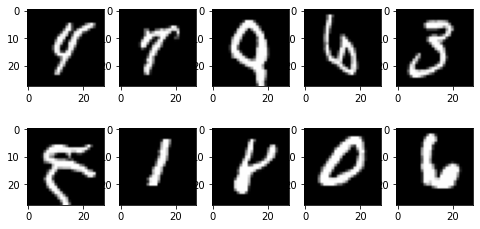

In [19]:
fig = plt.figure(figsize=(8, 4))
columns = 5
rows = 2
for i, img in enumerate(sampled_images):
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(img.squeeze().cpu().numpy(), cmap="gray")
plt.show()

## Conditional PixelCNN

A conditional `PixelCNN` conditions the model on the label. So that when we provide the trained model with a label of 1, the image should correspond to the label. That way we gain control over what images we produce.

We do the conditioning in the residial block, by generating two embeddings, that we add to the previous vertical and horizontal stack respectively.

In [20]:
class ConditionalGatedResidualBlock(nn.Module):

    def __init__(self, in_channels, kernel_size=3, dilation=1):
        super().__init__()
        self.v = VerticalStackConvolution(in_channels, out_channels=2*in_channels, kernel_size=kernel_size, dilation=dilation)
        self.h = HorizontalStackConvolution(in_channels, out_channels=2*in_channels, kernel_size=kernel_size, dilation=dilation)
        self.v_to_h = nn.Conv2d(2*in_channels, 2*in_channels, kernel_size=1)
        self.v_to_res = nn.Conv2d(in_channels, in_channels, kernel_size=1)
        
        self.v_embedding = nn.Embedding(num_embeddings=10, embedding_dim=in_channels)
        self.h_embedding = nn.Embedding(num_embeddings=10, embedding_dim=in_channels)

    def forward(self, v_prev, h_prev, num_cls):
        # calculate embeddings to condition the model
        v_embedding = self.v_embedding(num_cls).unsqueeze(-1).unsqueeze(-1)
        h_embedding = self.h_embedding(num_cls).unsqueeze(-1).unsqueeze(-1)

        # vertical stack
        v = self.v(v_prev + v_embedding)
        v_f, v_g = v.chunk(2, dim=1)
        v_out = torch.tanh(v_f) * torch.sigmoid(v_g)

        # vertical to horizontal
        v_to_h = self.v_to_h(v)
        
        # horizontal stack
        h = self.h(h_prev + h_embedding) + v_to_h
        h_f, h_g = h.chunk(2, dim=1)
        h_out = torch.tanh(h_f) * torch.sigmoid(h_g)
        
        # skip connection
        h_out = self.v_to_res(h_out)
        h_out += h_prev

        return v_out, h_out

The model is almost identical. The only difference is the label that we provide to each gated layer in the forward pass.

In [21]:
class ConditionalGatedPixelCNN(nn.Module):
    def __init__(self, hidden_dim, dilations=[1, 2, 1, 4, 1, 2, 1]):
        super().__init__()
        self.v = VerticalStackConvolution(in_channels=1,
                                          out_channels=hidden_dim,
                                          kernel_size=7,
                                          mask_type='A')
        self.h = HorizontalStackConvolution(in_channels=1,
                                          kernel_size=7,
                                          out_channels=hidden_dim,
                                          mask_type='A')
        
        self.gated_residual_blocks = nn.ModuleList([ConditionalGatedResidualBlock(hidden_dim, kernel_size=3, dilation=dilation) 
                                                 for dilation in dilations])
        
        self.conv = nn.Conv2d(in_channels=hidden_dim, 
                              out_channels=hidden_dim,
                              kernel_size=1)
        
        # we apply a 256 way softmax
        self.output = nn.Conv2d(in_channels=hidden_dim, 
                                out_channels=256,
                                kernel_size=1)
    def forward(self, x, label):
        v = self.v(x)
        h = self.h(x)
        
        for gated_layer in self.gated_residual_blocks:
            v, h = gated_layer(v, h, label)
        
        out = self.conv(F.relu(h))
        out = self.output(F.relu(out))
        # from Batch, Classes, Height, Width to Batch, Classes, Channel, Height, Width
        out = out.unsqueeze(dim=2)
        return out

In [22]:
model = ConditionalGatedPixelCNN(hidden_dim=HIDDEN_DIM).to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=5, min_lr=MIN_LEARNING_RATE, verbose=True)

In [23]:
# training loop
def train():
    best_loss = float("inf")
    scaler = torch.cuda.amp.GradScaler()
    for epoch in range(NUM_EPOCHS):
        start_time = time.time()
        train_losses = []
        test_losses = []
        for features, labels in train_dataloader:
            optimizer.zero_grad()

            features = features.to(DEVICE)
            labels = labels.to(DEVICE)
            with torch.amp.autocast(device_type="cuda", dtype=torch.float16):
                logits = model(features.float() / 255, labels)
                loss = criterion(logits, features.long())

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            train_losses.append(loss.cpu().item())


        # evaluate on the test dataset
        with torch.inference_mode():
            for features, labels in test_dataloader:
                features = features.to(DEVICE)
                labels = labels.to(DEVICE)
                with torch.amp.autocast(device_type="cuda", dtype=torch.float16):
                    logits = model(features.float() / 255, labels)
                    loss = criterion(logits, features.long())
                test_losses.append(loss.cpu().item())

        end_time = time.time()
        ce_train = sum(train_losses)/len(train_losses)
        ce_test = sum(test_losses)/len(test_losses)
        print(f'Epoch: {epoch+1}/{NUM_EPOCHS}, Cross Entropy Train: {ce_train:.4f}, Cross Entropy Test: {ce_test:.4f}, Elapsed Time: {end_time-start_time:.2f}sec')

        if ce_test < best_loss:
            print("Saving Weights")
            best_loss = ce_test
            torch.save(model.state_dict(), f=weights_path / 'conditional_gated_pixel_cnn.pt')
        scheduler.step(ce_test)

In [24]:
train()

Epoch: 1/100, Cross Entropy Train: 1.0311, Cross Entropy Test: 0.8233, Elapsed Time: 17.74sec
Saving Weights
Epoch: 2/100, Cross Entropy Train: 0.8133, Cross Entropy Test: 0.7969, Elapsed Time: 17.77sec
Saving Weights
Epoch: 3/100, Cross Entropy Train: 0.7924, Cross Entropy Test: 0.7832, Elapsed Time: 17.49sec
Saving Weights
Epoch: 4/100, Cross Entropy Train: 0.7805, Cross Entropy Test: 0.7724, Elapsed Time: 17.49sec
Saving Weights
Epoch: 5/100, Cross Entropy Train: 0.7725, Cross Entropy Test: 0.7671, Elapsed Time: 18.02sec
Saving Weights
Epoch: 6/100, Cross Entropy Train: 0.7664, Cross Entropy Test: 0.7605, Elapsed Time: 17.62sec
Saving Weights
Epoch: 7/100, Cross Entropy Train: 0.7613, Cross Entropy Test: 0.7554, Elapsed Time: 17.60sec
Saving Weights
Epoch: 8/100, Cross Entropy Train: 0.7571, Cross Entropy Test: 0.7519, Elapsed Time: 17.74sec
Saving Weights
Epoch: 9/100, Cross Entropy Train: 0.7531, Cross Entropy Test: 0.7470, Elapsed Time: 17.47sec
Saving Weights
Epoch: 10/100, Cros

In [25]:
model.load_state_dict(torch.load(f=weights_path / 'conditional_gated_pixel_cnn.pt'))

<All keys matched successfully>

In [26]:
@torch.inference_mode()
def sample(model, num_images):
    width = 28
    height = 28
    img = torch.zeros((num_images, 1, height, width), device=DEVICE)
    for h in range(height):
        for w in range(width):
                labels = torch.arange(10, device=DEVICE)
                pred = model(img / 255.0, labels)[:, :, :, h, w].squeeze()
                probs = F.softmax(pred, dim=1)
                sampled = torch.multinomial(probs, num_samples=1).squeeze(dim=-1)
                img[:, 0, h, w] = sampled
    return img

In [27]:
sampled_images = sample(model, 10)

The quality of the results are better and we are able to generate numbers that we desire.

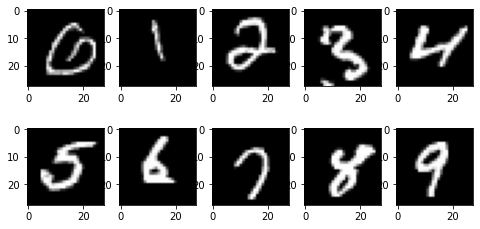

In [28]:
fig = plt.figure(figsize=(8, 4))
columns = 5
rows = 2
for i, img in enumerate(sampled_images):
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(img.squeeze().cpu().numpy(), cmap="gray")
plt.show()